In [1]:
from wolpertinger_net import *
sess = tf.Session()
net = WolpertingerNet(sess, seq_len=32, lr=0.0001)
%load_ext line_profiler

In [2]:
import os
import pickle

data = {}
for f in os.listdir('data/genes'):
    data[f[:-2]] = pickle.load(open('data/genes/' + f, 'rb'), encoding='latin1')
    
labels = [x for x in data]
testing = ['LCE6A','RCOR3','KLHL20','GPR137B','USH2A','SMYD3',
           'CNIH3','CFHR2','WDYHV1','OPN3','TNN',
           'CAMK1G','LENEP','CYB5R1','EPHX1']
training = [x for x in labels if x not in testing]

val = []
tran = []
tran_times = []
val_times = []

In [3]:
for x in data:
    print(x, len(data[x]))

HHAT 146
RASAL2 323
CKS1B 14
PEA15 36
SPRTN 119
PEX11B 78
OR6Y1 99
DPYS 135
GPA33 90
PPFIA4 885
DERL1 53
RNPEP 199
NTPCR 34
SPRR2F 31
SMG5 292
CCT3 124
PRRX1 81
MLLT11 25
QSOX1 259
PSMD4 95
CD5L 112
KCNK1 120
CD34 107
SOX13 203
ARHGEF11 454
FCRL5 289
IRF6 138
NCSTN 155
OAZ3 37
BCAN 368
DUSP27 452
FCGR2B 80
S100A13 23
FCER1G 8
KCNK2 93
SPRR2G 35
TMEM9 47
ZNF695 86
SPRR2E 31
MRPL13 16
GPR137B 93
PFKFB2 102
SLAMF6 60
PIP5K1A 107
NEK7 32
LCE3E 49
HIST3H2BB 40
CAPN2 174
NOS1AP 165
DDX59 116
TNR 441
DCSTAMP 126
FMN2 739
FMO2 95
USP21 187
TSACC 21
CD1E 122
TMEM79 171
LCE2A 49
FCAMR 208
OR6N2 84
EDARADD 52
MAEL 74
OR2B11 126
SNAP47 141
S100A2 22
NUDT17 96
BATF3 34
RABIF 39
OR6K6 107
TATDN3 26
ATF3 42
FBXO28 91
RAB3GAP2 231
OR6F1 100
ZNF672 176
FCGR3A 69
ANGPTL1 111
POGK 184
XPR1 119
UBE2T 33
TTC24 235
MUC1 169
PFDN2 30
RC3H1 283
FLAD1 235
MDM4 80
FAM89A 62
SF3B4 175
GPR89B 60
SPRR2B 32
MGST3 29
PDE4DIP 750
TMCO1 33
AGT 195
NPHS2 113
PGLYRP4 117
HLX 195
POLR3GL 37
SRP9 5
CERS2 89
LCE1C 48
NMNAT

In [7]:
def get_time_top3(dataset):
    test_data = data[random.choice(dataset)]

    s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
    top3 = sorted(test_data, key=lambda x: x[1])[-3:]

    for i, (state, action, reward) in enumerate(zip(s, a, r)):
        best_seen = state[-1]# max(state, key=lambda x: x[1])
        if vec_dna(best_seen[0]) in [x[0] for x in top3]:
            return i
    return 20


In [16]:
from tqdm import trange
import random 
for i in trange(2000):
    gene = random.choice(training)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    #%lprun -f SeqNet.multi_path net.train(samples, 10)
    tran.append(net.train(samples, 5, 16))
    gene = random.choice(testing)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    tran_times.append(get_time_top3(training))
    val_times.append(get_time_top3(testing))
    if i % 2 + 1:
        val.append(net.evaluate(samples, 5))
    else:
        val.append(val[-1])

 55%|█████▌    | 1103/2000 [28:05<21:22,  1.43s/it] 

KeyboardInterrupt: 

In [21]:
net.eps

0.48154244063014345

In [22]:
# Save weights

saver = tf.train.Saver()
saver.save(net.sess, 'results/model.ckpt')

'results/model.ckpt'

In [53]:
# Load weights

saver = tf.train.Saver()
saver.restore(net.sess, 'results/model.ckpt')

INFO:tensorflow:Restoring parameters from results/model.ckpt


In [23]:
# Save training data

pickle.dump(val, open('results/validation.p', 'wb'))
pickle.dump(tran, open('results/training.p', 'wb'))
pickle.dump(tran_times, open('results/tran_times.p', 'wb'))
pickle.dump(val_times, open('results/val_times.p', 'wb'))

In [8]:
import pickle
# Load old data

val = pickle.load(open('results/validation.p', 'rb'))
tran = pickle.load(open('results/training.p', 'rb'))
tran_times = pickle.load(open('results/tran_times.p', 'rb'))
val_times = pickle.load(open('results/val_times.p', 'rb'))

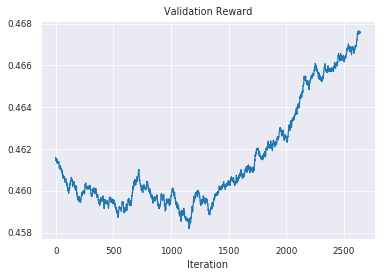

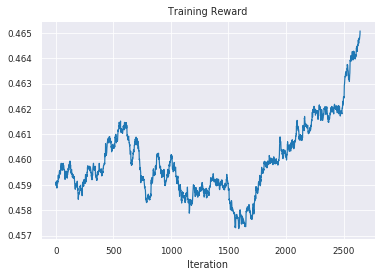

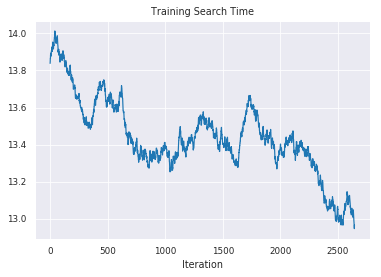

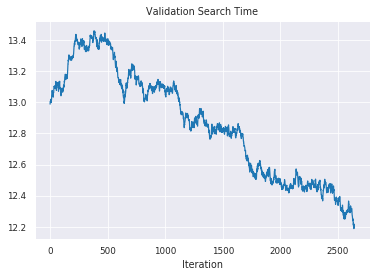

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')

gsmooth = 1000

smooth = gsmooth
plt.title('Validation Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/validation.png')
plt.show()

smooth = gsmooth
plt.title('Training Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/training.png')
plt.show()

smooth = gsmooth
plt.title('Training Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran_times, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/tran_time.png')
plt.show()

smooth = gsmooth
plt.title('Validation Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(val_times, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/val_time.png')
plt.show()

In [18]:
times = []

In [19]:
test_data = data[random.choice(testing)]

s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
top3 = sorted(test_data, key=lambda x: x[1])[-3:]
done = 0

print('top 3')
for x in top3:
    print(*x)

print()
print('state\t\t\t\t\t', 'rate\t\t', 'action\t\t\t\t\t', 'reward\t\t')
for i, (state, action, reward) in enumerate(zip(s, ns, r)):
    best_seen = state[-1]# max(state, key=lambda x: x[1])
    if vec_dna(best_seen[0]) in [x[0] for x in top3] and not done:
        times.append(i)
        done = 1
    print(vec_dna(best_seen[0]), '\t', '%.5f' % best_seen[1], '\t', vec_dna(action), '\t', '%.5f' % reward)

top 3
GGGCCCCTCGAGACACTGGGCTGCGGGTGCCT 0.6414389559187056
TGGGCACAGGGTGGGAGGGCTTCCAGCGGACC 0.6490762050220428
CTTCCTCGGAACTGTTGCCCACATGCAGCCCC 0.6651134648337103

state					 rate		 action					 reward		
AAGTCGCCTACATCCTCCTCTGCTGCTGGTGT 	 0.43631 	 GCCCCTCGAGACACTGGGCTGCGGGTGCCTGT 	 0.53417
GCCCCTCGAGACACTGGGCTGCGGGTGCCTGT 	 0.53417 	 AAGTCGCCTACATCCTCCTCTGCTGCTGGTGT 	 0.43631
AAGTCGCCTACATCCTCCTCTGCTGCTGGTGT 	 0.43631 	 CTGCTGCTGGTGTATCAAGGAACTGCTGGATT 	 0.43908
CTGCTGCTGGTGTATCAAGGAACTGCTGGATT 	 0.43908 	 TGGGCACAGGGTGGGAGGGCTTCCAGCGGACC 	 0.64908
TGGGCACAGGGTGGGAGGGCTTCCAGCGGACC 	 0.64908 	 CGGGTGCCTGTCATTAAGATGGGCACAGGGTG 	 0.46134
CGGGTGCCTGTCATTAAGATGGGCACAGGGTG 	 0.46134 	 TGGGCTGCGGGTGCCTGTCATTAAGATGGGCA 	 0.39122
TGGGCTGCGGGTGCCTGTCATTAAGATGGGCA 	 0.39122 	 ACACCCTTCCTCGGAACTGTTGCCCACATGCA 	 0.61356
ACACCCTTCCTCGGAACTGTTGCCCACATGCA 	 0.61356 	 AAACCCTACCCTTCTTCCTCGGAGGGGCCCCT 	 0.60319
AAACCCTACCCTTCTTCCTCGGAGGGGCCCCT 	 0.60319 	 CAGCCCCTAGCCCAAACCCTACCCTTCTTCCT 	 0.40606
CAGCCC

In [12]:
print(np.mean(np.array(times)))

7.0
